<a href="https://colab.research.google.com/github/a-r-williamson/nikhef-2021-gw/blob/main/notebooks/tutorial_1_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gravitational Wave Data Analysis 1: Finding Signals

In this notebook we will use the gravitational wave data analysis toolkit called `PyCBC` to download, read and process real gravitational wave data. By the end we should be able to identify the times of some real gravitational wave events.

In order to reach this goal we will need to learn how to handle data from the LIGO and Virgo observatories, including how to do the necessary data conditioning and matched filtering. Further, more technical reading on this topic can be found in [Abbott et al. (2020)](https://dx.doi.org/10.1088/1361-6382/ab685e)[[arXiv:1908.11170]](https://arxiv.org/abs/1908.11170).

This tutorial is based on tutorials from the [Gravitational Wave Open Data Workshop](https://github.com/gw-odw) and [`PyCBC` Tutorials](https://github.com/gwastro/PyCBC-Tutorials) repositories, taking code and inspiration heavily from both. I recommend looking at these resources for other examples as we will not cover all of the same things here.

## 0. Setting up the environment
First, we need to make sure the required software is installed in this environment. This notebook can be run on a remote server in Google Colaboratory, but if you want you can also download to your own machine, so long as you have a working `python` installation with all the required packages.

We want to have `PyCBC` and all its dependencies. These include the `lalsuite` and `ligo-common` packages, which contain a lot of the underlying code for handling the data and generating model gravitational wave signals.

In [1]:
import sys
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir
from IPython.display import Math
from matplotlib import pyplot as plt, rc, cycler
import seaborn as sns
#sns.set()
#plt.style.use('seaborn-colorblind')
palette = sns.color_palette("colorblind")
palette[3], palette[5] = palette[5], palette[3]
rc("axes", prop_cycle=cycler(color=palette))
alpha=0.5
import numpy as np

## 1. Downloading and manipulating data from the Gravitational Wave Open Science Center

The Gravitational Wave Open Science Center (GWOSC – [gw-openscience.org](https://www.gw-openscience.org)) contains public resources and data from the gravitational wave detectors.

Not all data is immediately made public but the data surrounding the time of all published detection candidates is made public at time of publication. Later, after a proprietory period, the data from entire observing runs are made available.

Let's begin by accessing the data surrounding one event using the `pycbc.catalog` module.

In [2]:
from pycbc import catalog

# Retreive an event's information (including data)
event_name = "GW190521" # https://www.gw-openscience.org/eventapi/html/GWTC-2/GW190521/v3/
catalog_name = "GWTC-2"

m = catalog.Merger(event_name, source=catalog_name)

# Print out some of this event's parameters
msg = r"\text{{Event {} occurred at GPS time {} with component masses }}".format(m.common_name, m.time)
msg += r"m_1 = {}^{{+{}}}_{{{}}} \, M_{{\odot}}".format(m.mass1, m._raw_mass_1_source_upper, m._raw_mass_1_source_lower)
msg += r"\text{{ and }}"
msg += r"m_2 = {}^{{+{}}}_{{{}}} \, M_{{\odot}}".format(m.mass2, m._raw_mass_2_source_upper, m._raw_mass_2_source_lower)
Math(msg)

<IPython.core.display.Math object>

Now we can take a look at the raw data in a plot...

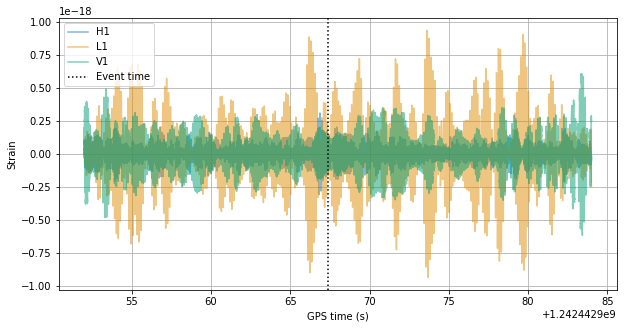

In [3]:
from pycbc import psd
import pycbc.filter as filt

# Initialise figure (matplotlib)
fig = plt.figure(figsize=[10, 5])
ax = fig.gca()

# List the detectors we want to include
ifos = ['H1', 'L1', 'V1']
for ifo in ifos:
    # Read in the data for each interferometer
    try:
        ts = m.strain(ifo)
    except:
        print("No {} data available! Check if this is expected. "
              "Removing from our list.".format(ifo))
        ifos.remove(ifo)
    ax.plot(ts.sample_times, ts, label=ifo, alpha=alpha)

ax.axvline(m.time, color="black", linestyle=":", label="Event time")
ax.set_ylabel('Strain')
ax.set_xlabel('GPS time (s)')
ax.grid()
ax.legend()
plt.show()
plt.close()

Note the scale of the y-axis. Gravitational wave signals observed by our observatories typically have peak strains of $\mathcal{O}(10^{-21})$ or less! In gravitational wave detector data signals are buried in noise. This is why we need to do some data conditioning/filtering to find and characterise them.

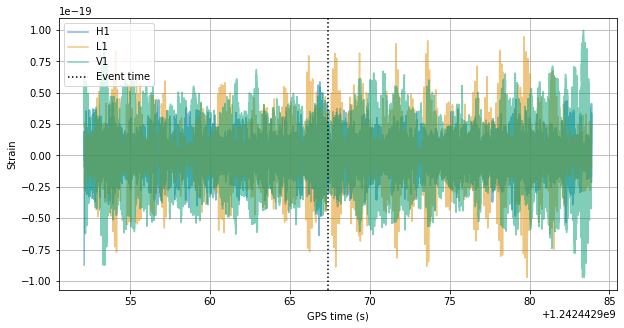

In [4]:
# Set up dictionary for storing output
data = {}

# Initialise figure
fig = plt.figure(figsize=[10, 5])
ax = plt.gca()

# Define our low frequency cut off
f_low = 14.0

for ifo in ifos:
    # Read in the data for each interferometer, this time using a finite impulse
    # response filter to remove high & low frequencies outside the signal range
    ts = m.strain(ifo).highpass_fir(12, 512)
    data[ifo] = filt.resample_to_delta_t(ts, 1.0/2048)
    ax.plot(data[ifo].sample_times, data[ifo], label=ifo, alpha=alpha)

ax.axvline(m.time, color="black", linestyle=":", label="Event time")
ax.set_ylabel('Strain')
ax.set_xlabel('GPS time (s)')
ax.grid()
ax.legend()
plt.show()
plt.close()

Better, but still much to do. Next, we should take a proper look at the noise spectrum of this data.

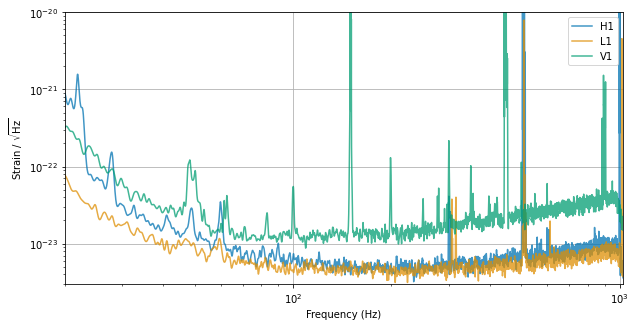

In [5]:
PSD = {}
ASD = {}
fig = plt.figure(figsize=[10, 5])
ax = plt.gca()

for ifo in ifos:
    # Estimate the power spectral density of the data
    # This chooses to use 2s samples in the PSD estimate.
    # One should note that the tradeoff in segment length is that
    # resolving narrow lines becomes more difficult.
    p = data[ifo].psd(2)
    p = psd.interpolate(p, data[ifo].delta_f)
    p = psd.inverse_spectrum_truncation(p, int(2 * data[ifo].sample_rate),
                                        low_frequency_cutoff=f_low)
    
    # The noise is often shown in terms of the amplitude spectral density, which
    # is the square root of the power spectral density
    PSD[ifo] = p
    ASD[ifo] = p**0.5
    
    ax.plot(ASD[ifo].sample_frequencies, ASD[ifo], label=ifo, alpha=0.75)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(3e-24, 1e-20)
ax.set_xlim(20, 1024)
ax.set_ylabel(r'Strain / $\sqrt{\mathrm{Hz}}$')
ax.set_xlabel('Frequency (Hz)')
ax.grid()
ax.legend()
plt.show()
plt.close()

We can see how the noise is more severe at lower frequencies, which is due primarily to seismic noise and some thermal noise in the instrument itself. At frequencies above a few hundred Hz the noise increases due to quantum shot noise.

You will notice that there are large spikes. These may be resonant frequencies of components in the interferometer, but also may be deliberately added for calibration purposes. This is fine for our transient searches since, generally speaking, the thinner these lines are, the less of an impact they will have on our matched filtering analysis (they are more of a problem for finding continuous/stochastic signals).

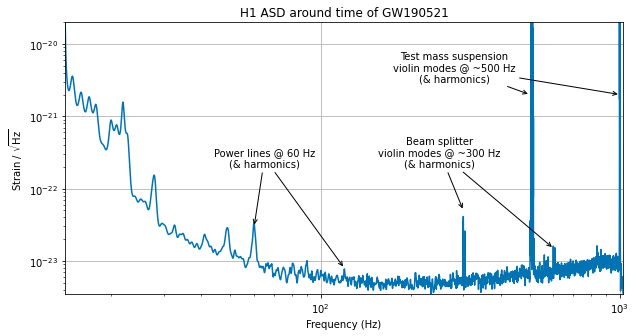

In [6]:
ifo = "H1"
arrowprops = {"arrowstyle": "->"}

fig = plt.figure(figsize=[10, 5])
ax = plt.gca()
ax.plot(ASD[ifo].sample_frequencies, ASD[ifo])

ax.annotate("Power lines @ 60 Hz\n(& harmonics)", (60, 3e-23), (65, 2e-22),
            ha="center", arrowprops=arrowprops)
ax.annotate("Power lines @ 60 Hz\n(& harmonics)", (120, 8e-24), (65, 2e-22),
            ha="center", arrowprops=arrowprops, alpha=0.0)

ax.annotate("Test mass suspension\nviolin modes @ ~500 Hz\n(& harmonics)", (500, 2e-21), (280, 3e-21),
            ha="center", arrowprops=arrowprops)
ax.annotate("Test mass suspension\nviolin modes @ ~500 Hz\n(& harmonics)", (1000, 2e-21), (280, 3e-21),
            ha="center", alpha=0.0, arrowprops=arrowprops)

ax.annotate("Beam splitter\nviolin modes @ ~300 Hz\n(& harmonics)", (300, 5e-23), (250, 2e-22),
            ha="center", arrowprops=arrowprops)
ax.annotate("Beam splitter\nviolin modes @ ~300 Hz\n(& harmonics)", (600, 1.5e-23), (250, 2e-22),
            ha="center", alpha=0.0, arrowprops=arrowprops)

ax.set_title("{} ASD around time of {}".format(ifo, m.common_name))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(3.5e-24, 2e-20)
ax.set_xlim(f_low, 1024)
ax.set_ylabel(r'Strain / $\sqrt{\mathrm{Hz}}$')
ax.set_xlabel('Frequency (Hz)')
ax.grid()
plt.show()
plt.close()

Now we can see what happens if we whiten the data. Whitening involves dividing by the noise PSD across the frequency range.

What will the data look like after this? Will it have nice properties, like Gaussianity?

Can we see the signal once we do this?

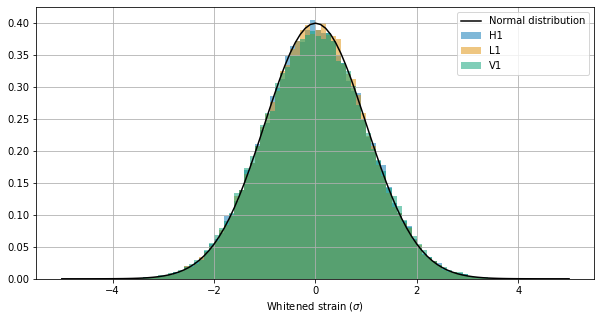

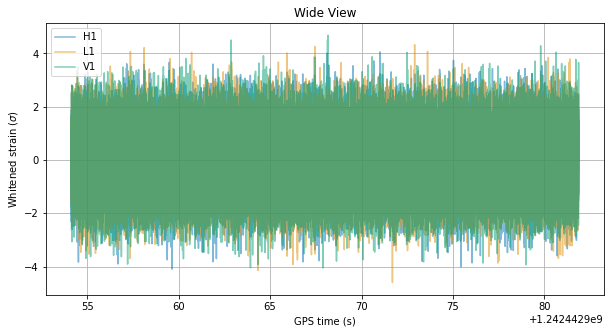

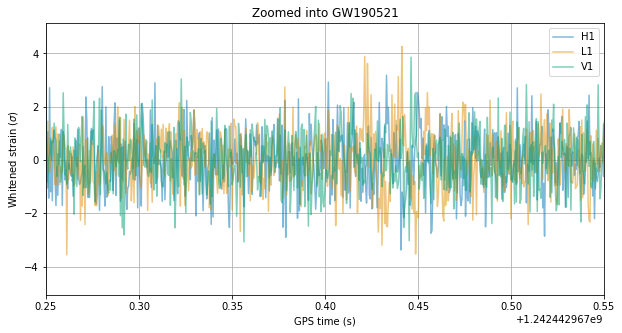

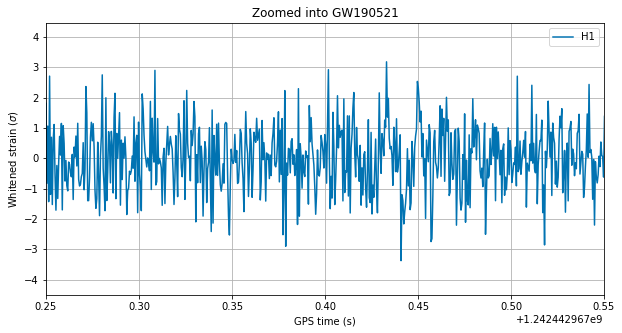

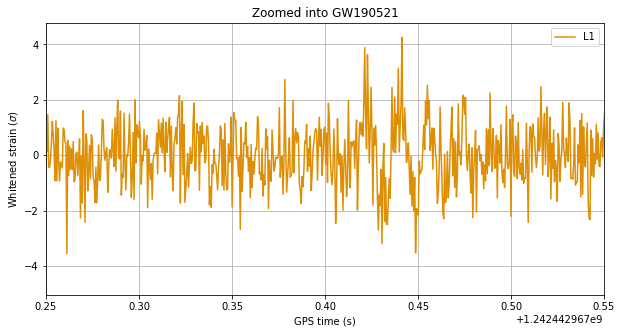

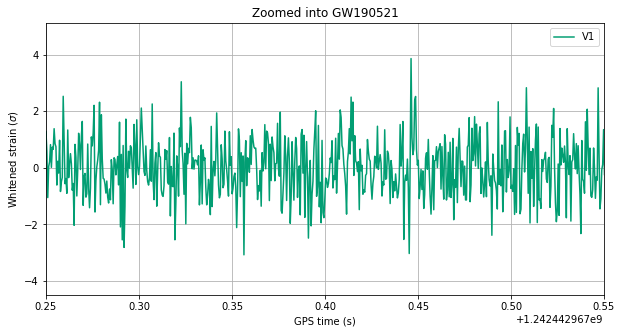

In [7]:
whitened = {}
colors = {}
for ifo in ifos:
    # Whiten by the PSD, including a normalisation of 1 / (2 * dt)
    norm = 1. / data[ifo].delta_t / 2.
    whitened_fs = data[ifo].to_frequencyseries() / (PSD[ifo] * norm)**0.5
    whitened[ifo] = whitened_fs.to_timeseries().crop(2,2)

# Are the whitened data Gaussian?
from scipy.stats import norm

fig = plt.figure(figsize=[10, 5])
ax = fig.gca()
bins = np.linspace(-5, 5, num=101)
for ifo in ifos:
    ax.hist(whitened[ifo], label=ifo, alpha=alpha, bins=bins, density=True)
ax.plot(bins, norm.pdf(bins), "k-", label="Normal distribution")
ax.legend()
ax.grid()
ax.set_xlabel(r"Whitened strain ($\sigma$)")
plt.show()
plt.close()

for w, title in [(None, "Wide View"), (.15, "Zoomed into {}".format(m.common_name))]:
    fig = plt.figure(figsize=[10, 5])
    ax = fig.gca()
    for ifo in ifos:
        l = ax.plot(whitened[ifo].sample_times, whitened[ifo], label=ifo,
                    alpha=alpha)
        colors[ifo] = l[0].get_color()
        if w is not None:
            fig2 = plt.figure(figsize=[10, 5])
            ax2 = fig2.gca()
            ax2.plot(whitened[ifo].sample_times, whitened[ifo], label=ifo,
                     color=colors[ifo])
            ax2.legend()
            ax2.set_title(title)
            ax2.grid()
            ax2.set_xlim(m.time - w, m.time + w)
            ax2.set_ylabel(r"Whitened strain ($\sigma$)")
            ax2.set_xlabel('GPS time (s)')
            fig2.show()
    ax.legend()
    ax.set_title(title)
    ax.grid()
    if w is not None:
        ax.set_xlim(m.time - w, m.time + w)
    ax.set_ylabel(r"Whitened strain ($\sigma$)")
    ax.set_xlabel('GPS time (s)')
    plt.show()
    plt.close()

There is a period of some excited strain around 0.40–0.46 on the zoomed in plot for L1 that looks like it has some correlated oscillatory pattern to it. We might actually be able to do a bit better here by getting rid of the high frequency end of the noise with a lowpass filter (as we will see, our signal is very low frequency, so we won't be throwing away signal).

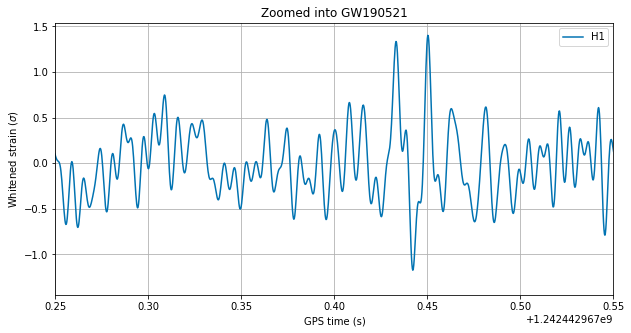

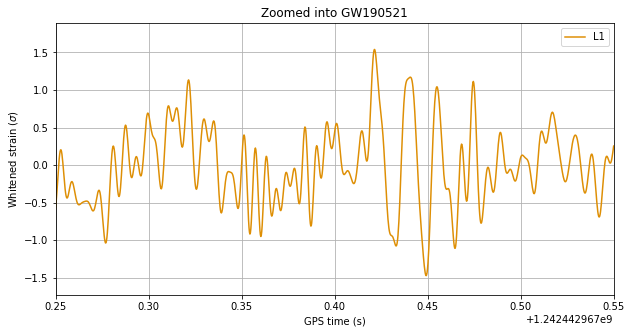

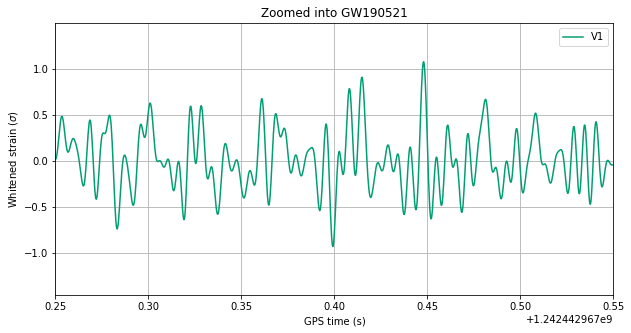

In [8]:
bpassed = {}
for ifo in ifos:
    # Put all the steps above together, adding a lowpass filter
    ts = m.strain(ifo)
    # Estimate PSD
    p = ts.psd(2)
    p = psd.interpolate(p, ts.delta_f)
    p = psd.inverse_spectrum_truncation(p, int(2 * ts.sample_rate),
                                        low_frequency_cutoff=f_low)
    # Whiten
    norm = 1. / ts.delta_t / 2.
    wh = (ts.to_frequencyseries() / (p * norm)**0.5).to_timeseries().crop(2,2)
    
    # Highpass and lowpass
    bpassed[ifo] = wh.highpass_fir(12, 512).lowpass_fir(192, 512)

    fig = plt.figure(figsize=[10, 5])
    ax = fig.gca()
    ax.plot(bpassed[ifo].sample_times, bpassed[ifo], label=ifo, color=colors[ifo])
    ax.legend()
    ax.set_title(title)
    ax.grid()
    ax.set_xlim(m.time - 0.15, m.time + 0.15)
    ax.set_ylabel(r"Whitened strain ($\sigma$)")
    ax.set_xlabel('GPS time (s)')
    plt.show()
    plt.close()

## 2. Matched filtering with model templates

We are now ready to matched filter the data to see if we can find a signal contained there. This will generate a signal-to-noise (SNR) time series. Spikes will indicate times when the template has a better than average match. However, as we will see, gravitational wave signals are not the only things that can lead to spikes in SNR. Non-Gaussian noise fluctuations, often referred to as "glitches", can also create these spikes. However, we can employ further processing to try to reject noise in favour of signals.

Let's now generate a template waveform using parameters that we know are reasonably representative of the signal and use that template to filter the data. This will be a rough but quick approach.

To begin with, we must remember that the event's listed parameters are in the ***source*** frame, i.e. represent the physical parameters of the system. But we observe a gravitational wave signal here on Earth. That means the signal may appear redshifted in the frame of our detectors due to cosmological expansion, as often happens in other fields within astronomy, so we need to account for this.

Redshift is 0.72. Therefore 91.4 -> 157.208 and 66.8 -> 114.89599999999999


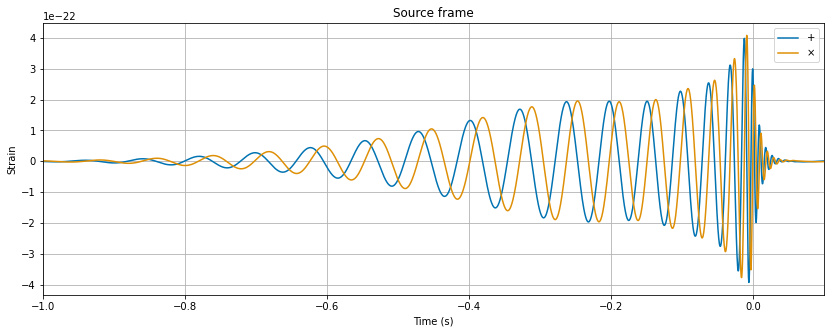

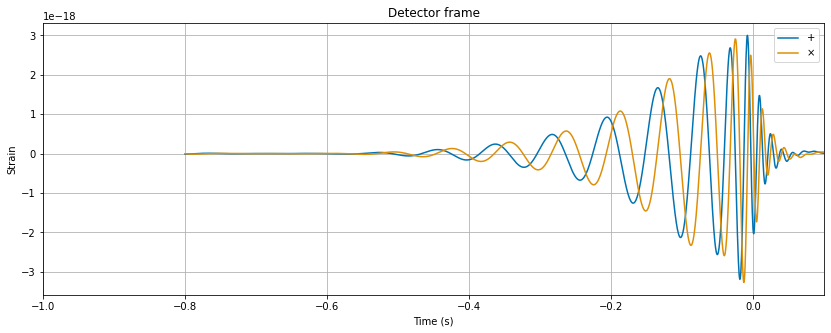

In [9]:
from pycbc import waveform as wf, conversions as conv

# Calculate the component mass of each black hole in the detector frame
m1_det = m.mass1 * (1 + m.z)
m2_det = m.mass2 * (1 + m.z)
print("Redshift is {}. Therefore {} -> {} and {} -> {}".format(m.z, m.mass1, m1_det, m.mass2, m2_det))

# Generate signals in the time domain and see the redshift effect
# First the *source* frame
hp_src, hc_src = wf.get_td_waveform(approximant="IMRPhenomD",
                                    mass1=m.mass1, mass2=m.mass2, distance=m.distance,
                                    f_lower=f_low, delta_t=data[ifo].delta_t)

fig = plt.figure(figsize=[14, 5])
ax = plt.gca()
ax.plot(hp_src.sample_times, hp_src, label=r"$+$")
ax.plot(hc_src.sample_times, hc_src, label=r"$\times$")
ax.legend()
ax.set_title("Source frame")
ax.grid()
ax.set_xlim(-1.0, 0.1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Strain')
plt.show()
plt.close()

# Now in the *detector* (Earth) frame
hp_det, hc_det = wf.get_td_waveform(approximant="IMRPhenomD",
                                    mass1=m1_det, mass2=m2_det,
                                    f_lower=f_low, delta_t=data[ifo].delta_t)

fig = plt.figure(figsize=[14, 5])
ax = plt.gca()
ax.plot(hp_det.sample_times, hp_det, label=r"$+$")
ax.plot(hc_det.sample_times, hc_det, label=r"$\times$")
ax.legend()
ax.set_title("Detector frame")
ax.grid()
ax.set_xlim(-1.0, 0.1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Strain')
plt.show()
plt.close()

We can see here how the cosmological redshift effect stretches the signal out to lower frequencies. Clearly, for a source at this distance, if we didn't account for this redshift our analysis would be significantly affected.

We can now use the detector frame masses to generate a ***frequency domain*** waveform and use that to filter the data.

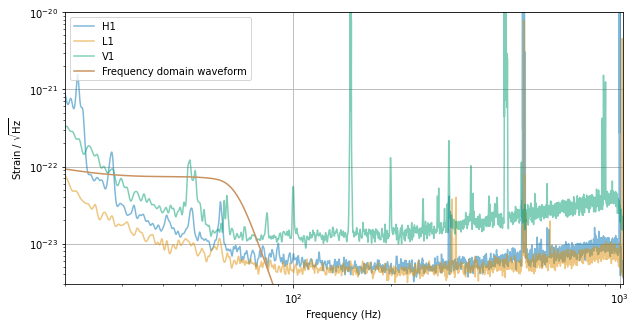

In [10]:
# This is a frequency domain waveform generator. It has a very similar syntax to the time domain
# waveform function used above. This function returns both a plus and a cross
# polarization waveform, but we will just use the plus polarization in building our template
# as these are only different by a phase offset in this specific case.
hp, hc = wf.get_fd_waveform(approximant="IMRPhenomD",
                            mass1=m1_det, mass2=m2_det, distance=m.distance,
                            f_lower=f_low, delta_f=data[ifo].delta_f)


# Plot this frequency domain waveform and compare to the noise in our detectors
fig = plt.figure(figsize=[10, 5])
ax = plt.gca()
for ifo in ifos:
    # Plot each detector's ASD
    ax.plot(ASD[ifo].sample_frequencies, ASD[ifo], label=ifo, alpha=alpha)
# Plot the waveform. We must scale by the sqrt(Hz) factor to make the comparison
ax.plot(hp.sample_frequencies, abs(hp) * np.sqrt(hp.sample_frequencies),
        label="Frequency domain waveform")
ax.grid()
ax.legend()
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel(r'Strain / $\sqrt{\mathrm{Hz}}$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(3e-24, 1e-20)
ax.set_xlim(20, 1024)
plt.show()
plt.close()

The signal appears above the noise level in all three interferometers but to differing degrees. Note how the merger happens at <70 Hz! This emphasises that LIGO and Virgo will struggle to observe merger events that are sufficiently massive.

Based on this plot – and ignoring a number of caveats (e.g. each detector will have a different fractional sensitivity/response in the direction of the signal source) – we might expect the signal to have the largest SNR in LIGO-Livingston (L1) and the smallest in Virgo (V1).

Let's see if this is correct by using the template to filter the data properly.

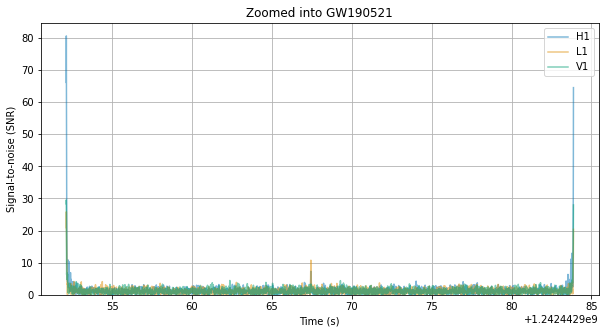

In [11]:
# For each observatory use this template to calculate the SNR time series
# Resize the array so it matches the length of the PSD arrays
hp.resize(len(PSD[ifo]))

fig = plt.figure(figsize=[10, 5])
ax = plt.gca()

snr_full = {}
for ifo in ifos:
    # Do matched filter, filtering data that has noise given by PSD with
    # template hp. We also pass a low frequency argument.
    snr_full[ifo] = filt.matched_filter(hp, data[ifo], psd=PSD[ifo],
                                        low_frequency_cutoff=f_low)
    ax.plot(snr_full[ifo].sample_times, abs(snr_full[ifo]), label=ifo,
            alpha=alpha)

ax.legend()
ax.set_title(title)
ax.grid()
ax.set_ylim(0, None)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal-to-noise (SNR)')
plt.show()
plt.close()

This first thing you might notice is the large spikes at either end. These are the result of filtering non-cyclical data; the algorithm treats the data like it is a ring, with the first and last data points connected. Since they are not actually related this will not be a smooth boundary, and the template will "ring" off on this discontinuity. We should ignore these corrupted times, so we will cut them off and replot, zooming in to the smaller spike we can see near the middle.

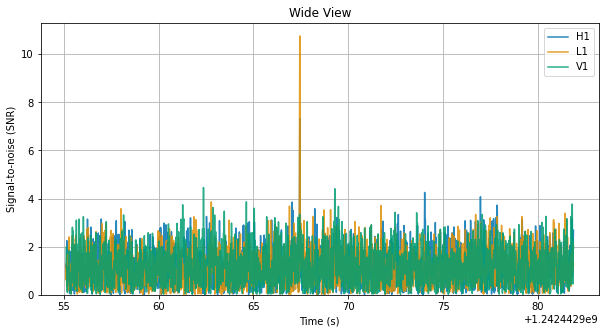

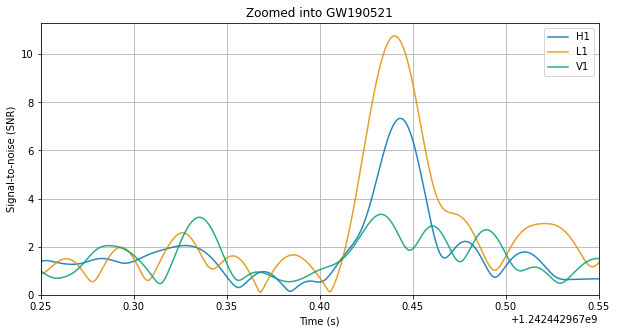

Maximum SNR in H1 =  7.33 at 1242442967.4434
Maximum SNR in L1 = 10.76 at 1242442967.4404
Maximum SNR in V1 =  3.34 at 1242442967.4331


In [12]:
snr = {}
peak = {}
# Crop out the corrupted time at either end
for ifo in ifos:
  snr[ifo] = snr_full[ifo].crop(3, 2)

# Show a couple of sizes
for w, title in [(None, "Wide View"), (.15, "Zoomed into {}".format(m.common_name))]:
    fig = plt.figure(figsize=[10, 5])
    ax = plt.gca()
    for ifo in ifos:
        ax.plot(snr[ifo].sample_times, abs(snr[ifo]), label=ifo,
                alpha=0.85)

    ax.legend()
    ax.set_title(title)
    ax.grid()
    if w is not None:
      ax.set_xlim(m.time - w, m.time + w)
    ax.set_ylim(0, None)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Signal-to-noise (SNR)')
    plt.show()
    plt.close()

# Find the local peaks
for ifo in ifos:
    sliced = snr[ifo].time_slice(m.time - w, m.time + w)
    pk, pidx = sliced.abs_max_loc()
    peak[ifo] = sliced.sample_times[pidx]
   
    print("Maximum SNR in {} = {:5.2f} at {:.4f}".format(ifo, pk, peak[ifo]))

There is quite a prominent spike in SNR in H1 and L1! As we had anticipated, L1 sees the largest SNR peak. Contrast this with V1. It's not clear to the eye whether there is a statistically significant detection here.

In practice, we do not stop our analyses with SNR. An SNR spike may be due to something that does not actually resemble our template very closely. We can test for this with a $\chi^2$-based signal consistency test. We employ a version of the test described [in this paper](https://arxiv.org/pdf/gr-qc/0405045.pdf). Schematically, we chop up our template into $p$ number of bins, chosen such that each should contain an equal amount of signal power. We then see how much each bin really contributes to the SNR ($\rho_i$). We can then calculate our statistic as the difference between the SNR in one bin, and the expected fraction of the total SNR ($\rho$).

$
\chi^2 = \sum^p_{i=0} (\rho_i - \rho / p)^2
$

This will have $2p−2$ degrees of freedom as each SNR is ***complex***, representing both possible orthogonal phases the signal could have contributions from. We will normalize this statistic by dividing by the number of degrees of freedom, producing a reduced $\chi^2_r$.

We expect that this statistic will be high when the template does not match the data well, and near unity when the data either is Gaussian noise, or it contains the expected signal in addition to Gaussian noise.

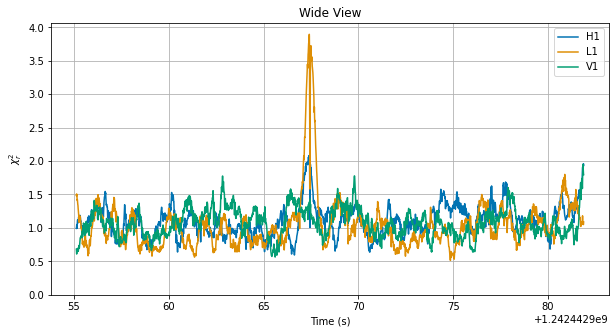

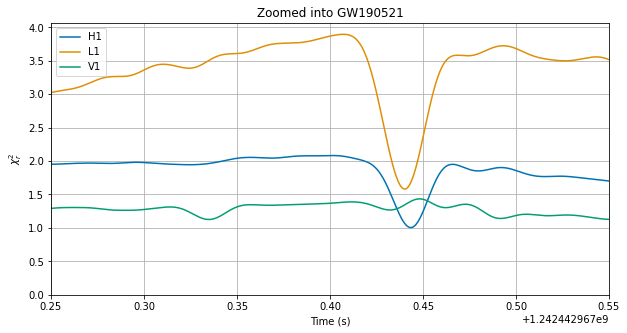

In [13]:
from pycbc.vetoes import power_chisq

chisq = {}
for ifo in ifos:
    # The number of bins to use. In principle, this choice is arbitrary. In practice,
    # this is empirically tuned.
    nbins = 26
    chisq[ifo] = power_chisq(hp, data[ifo], nbins, PSD[ifo], low_frequency_cutoff=f_low)
    chisq[ifo] = chisq[ifo].crop(3, 2)
    
    # Scale by the number of degrees of freedom
    dof = nbins * 2 - 2
    chisq[ifo] /= dof

# Show a couple of sizes
for w, title in [(None, "Wide View"), (.15, "Zoomed into {}".format(m.common_name))]:
    fig = plt.figure(figsize=[10, 5])
    ax = plt.gca()
    for ifo in ifos:
        ax.plot(chisq[ifo].sample_times, chisq[ifo], label=ifo)

    ax.legend()
    ax.set_title(title)
    ax.grid()
    if w is not None:
      ax.set_xlim(m.time - w, m.time + w)
    ax.set_ylim(0, None)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(r'$\chi^2_r$')
    plt.show()
    plt.close()

We can then use the reduced $\chi^2_r$ statistic to produce a detection statistic $\rho_{\mathrm{det}}$ that re-weights the matched-filter SNR $\rho$.

$
\rho_{\mathrm{det}} = \frac{\rho}{\left(\frac{1}{2}\left[1 + \left(\chi^2_r\right)^{\frac{q}{n}}\right]\right)^{\frac{1}{q}}}
$

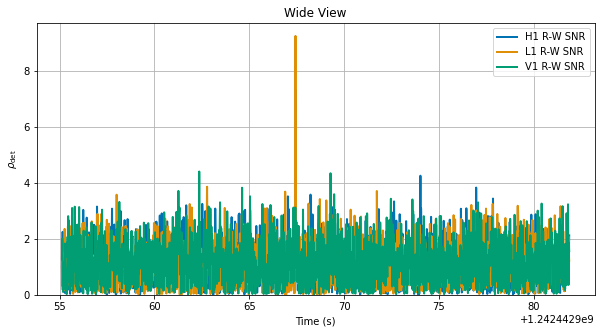

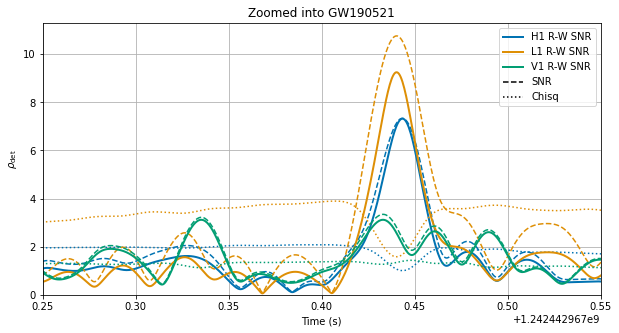

In [14]:
from pycbc.events.ranking import newsnr

# The re-weighted SNR statistic is sometimes known as "New SNR"
nsnr = {ifo:newsnr(abs(snr[ifo]), chisq[ifo]) for ifo in ifos}
peak_time = {}

# Show a couple of plots (zoomed, unzoomed)
for w, title in [(None, "Wide View"), (.15, "Zoomed into {}".format(m.common_name))]:
    fig = plt.figure(figsize=[10, 5])
    ax = plt.gca()
    for ifo in ifos:
        l = ax.plot(snr[ifo].sample_times, nsnr[ifo], linewidth=2,
                    label="{} R-W SNR".format(ifo))
        if w is not None:
            ax.plot(snr[ifo].sample_times, abs(snr[ifo]), "--", color=l[0].get_color())
            ax.plot(chisq[ifo].sample_times, chisq[ifo], ":", color=l[0].get_color())
    if w is not None:
        ax.set_xlim(m.time - w, m.time + w)
        handles, labels = ax.get_legend_handles_labels()
        snr_line = plt.Line2D([], [], color='black', linestyle="--", label="SNR")
        chisq_line = plt.Line2D([], [], color='black', linestyle=":", label="Chisq")
        ax.legend(handles=handles+[snr_line, chisq_line])
    else:
        ax.legend()
    ax.set_title(title)
    ax.grid()
    ax.set_ylim(0, None)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(r'$\rho_{\mathrm{det}}$')
    plt.show()
    plt.close()

for ifo in ifos:
    peak = abs(nsnr[ifo]).argmax()
    peak_time[ifo] = snr[ifo].sample_times[peak]

What we see here is that, in the H1 data, there are not very many times when the $\chi^2$ test down-weights the triggers. We already saw that the whitened data were close to Gaussian distributed, so this is not very surprising. In L1 we are seeing that the template perhaps doesn't fit the signal so well.

## 3. Residuals

We can see how well a template waveform compares to a signal by looking at the residuals (what's left over when we subtract the template). If our assumption is that the data are Gaussian noise + signal, then the residual should hopefully be Gaussian if our template is a good match for the signal.

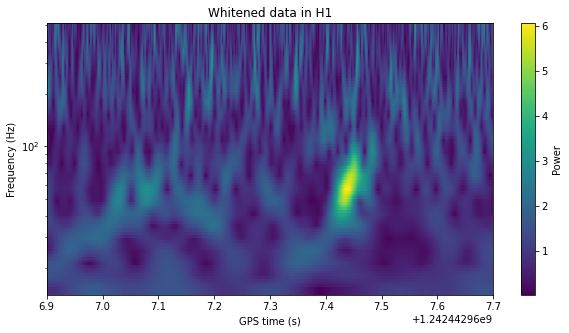

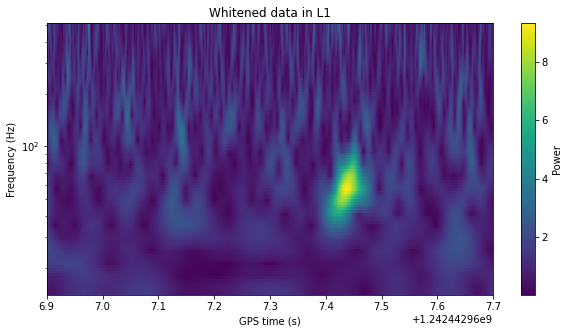

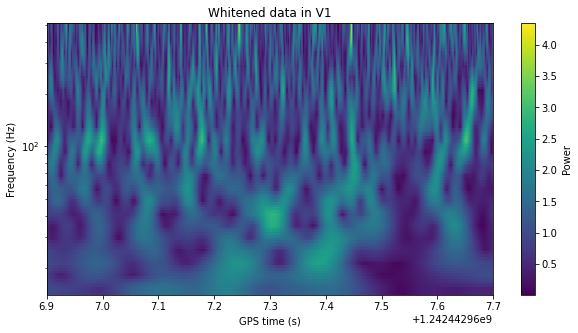

In [15]:
zoomed = {}

for ifo in ifos:
    fig = plt.figure(figsize=[10, 5])
    ax = fig.gca()
    zoomed[ifo] = whitened[ifo].time_slice(m.time - 5, m.time + 5)
    times, freqs, power = zoomed[ifo].qtransform(.001, logfsteps=100,
                                                 qrange=(6, 6),
                                                 frange=(f_low, 512))
    p = ax.pcolormesh(times, freqs, power**0.5)
    ax.set_title("Whitened data in {}".format(ifo))
    ax.set_yscale('log')
    ax.set_xlim(m.time - 0.5, m.time + 0.3)
    ax.set_ylabel("Frequency (Hz)")
    ax.set_xlabel("GPS time (s)")
    #ax.set_ylim(f_low, 512)
    plt.colorbar(p, ax=ax, label="Power")
    plt.show()
    plt.close()

There is a visible burst of power in the whitened data of H1 and L1 but not in V1. Note the colour scales. The signal was seen with more power in L1.

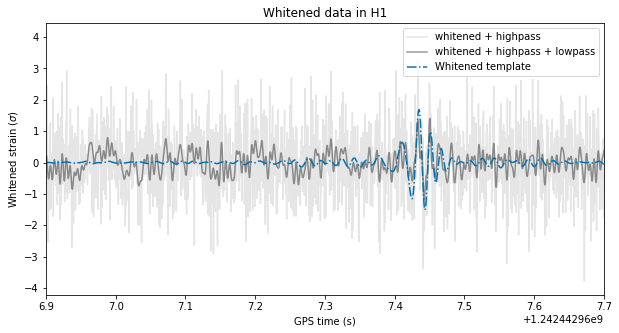

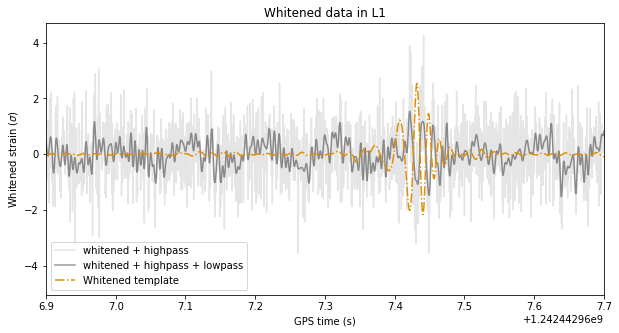

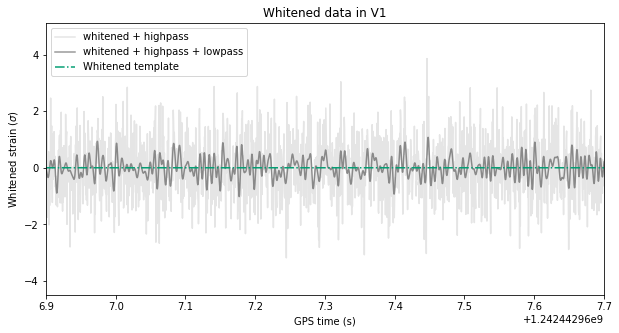

In [16]:
whitened_temp = {}
for ifo in ifos:
    dt = m.time - zoomed[ifo].start_time + hp.start_time
    aligned = hp.cyclic_time_shift(dt)
    norm = 1. / data[ifo].delta_t / 2.
    whitened_temp[ifo] = (aligned / (PSD[ifo] * norm)**0.5).to_timeseries().crop(2,2)
    whitened_temp[ifo].start_time += peak_time[ifo]
    
    fig = plt.figure(figsize=[10, 5])
    ax = fig.gca()
    ax.plot(zoomed[ifo].sample_times, zoomed[ifo], "k-", alpha=0.1,
            label="whitened + highpass")
    ax.plot(bpassed[ifo].sample_times, bpassed[ifo], "k-", alpha=0.4,
            label="whitened + highpass + lowpass")
    ax.plot(whitened_temp[ifo].sample_times, whitened_temp[ifo], "-.",
            color=colors[ifo], label="Whitened template")
    ax.set_title("Whitened data in {}".format(ifo))
    ax.set_xlim(m.time - 0.5, m.time + 0.3)
    ax.set_ylabel(r"Whitened strain ($\sigma$)")
    ax.set_xlabel("GPS time (s)")
    ax.legend()
    plt.show()
    plt.close()

We can see that our crude guess template doesn't give a great fit to the data (this was somewhat reflected by the $\chi^2$ values we saw). Let's instead take the parameters that produced the best fit model signal from a full parameter estimation analysis used in the discovery paper.

In [17]:
from astropy.utils.data import download_file

url = "https://dcc.ligo.org/public/0168/P2000158/004/GW190521_posterior_samples.h5"
fname = download_file(url, cache=True)

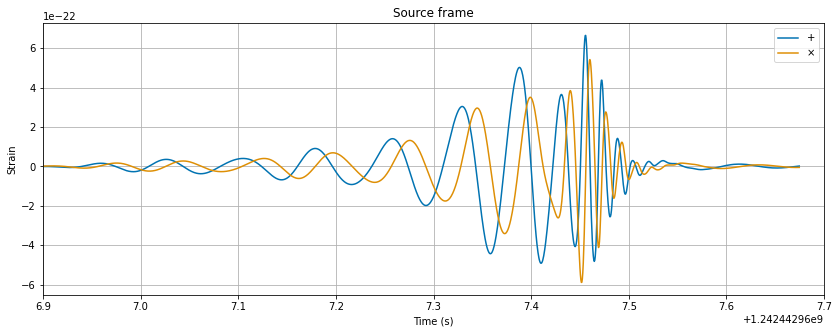

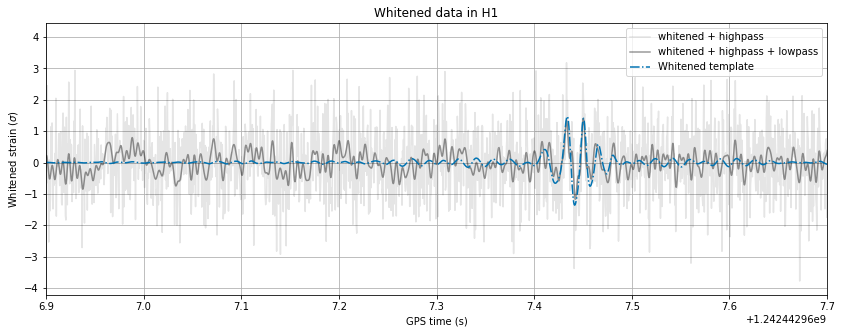

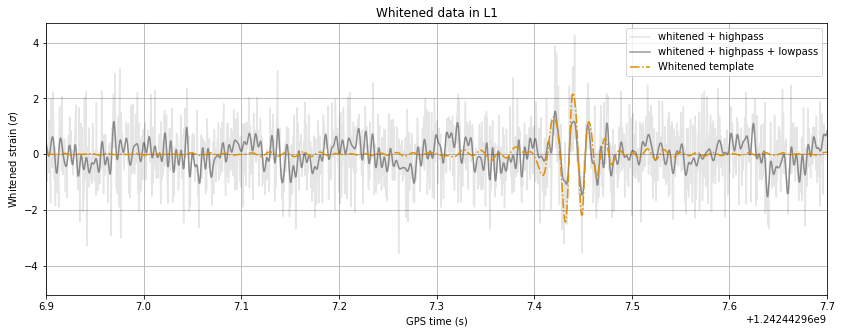

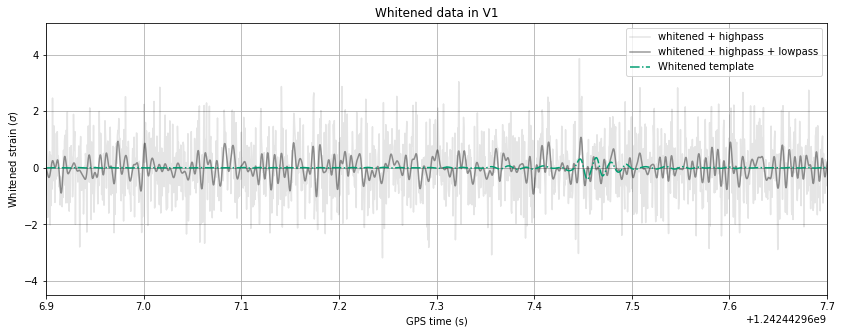

In [18]:
import h5py
from pycbc.detector import Detector

f_lower = 14.0

# Load the posterior samples
h = h5py.File(fname, "r")
#approx = "NRSur7dq4" # This model needs lalsuite-extra
approx = "IMRPhenomPv3HM"
samples = h[approx]['posterior_samples']

# Locate the parameter set that gave the maximum likelihood value
# (i.e., the best fit to the data)
maxL = samples["log_likelihood"].argmax()

wf_keys = ["mass_1", "mass_2", "spin_1x", "spin_1y", "spin_1z", "spin_2x", "spin_2y",
           "spin_2z"]
maxL_params = {key: samples[key][maxL] for key in samples.dtype.fields.keys()}

# Generate a waveform with these parameters
hp_maxL, hc_maxL = wf.get_td_waveform(approximant=approx,
                                      mass1=maxL_params["mass_1"],
                                      mass2=maxL_params["mass_2"],
                                      spin1x=maxL_params["spin_1x"],
                                      spin1y=maxL_params["spin_1y"],
                                      spin1z=maxL_params["spin_1z"],
                                      spin2x=maxL_params["spin_2x"],
                                      spin2y=maxL_params["spin_2y"],
                                      spin2z=maxL_params["spin_2z"],
                                      distance=maxL_params["luminosity_distance"],
                                      inclination=maxL_params["theta_jn"],
                                      coa_phase=maxL_params["phase"],
                                      f_lower=14.0,
                                      delta_t=data[ifo].delta_t)

hp_maxL.start_time += maxL_params["geocent_time"]
hc_maxL.start_time += maxL_params["geocent_time"]

# Plot this waveform
fig = plt.figure(figsize=[14, 5])
ax = plt.gca()
ax.plot(hp_maxL.sample_times, hp_maxL, label=r"$+$")
ax.plot(hc_maxL.sample_times, hc_maxL, label=r"$\times$")
ax.legend()
ax.set_title("Source frame")
ax.grid()
ax.set_xlim(m.time - 0.5, m.time + 0.3)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Strain')
plt.show()
plt.close()

# Project the signal onto each detector in turn, whiten, and compare to
# whitened bandpassed data
wht = {}
for ifo in ifos:
    # Initialise the Detector object representing the interferometer.
    # These are defined for each interferometer in our network and store the
    # locations and orientations of each one.
    det = Detector(ifo)
    
    # Project the signal onto the detector, given a location on the sky, time,
    # and polarisation angle.
    ht = det.project_wave(hp_maxL, hc_maxL, maxL_params["ra"], maxL_params["dec"],
                          maxL_params["psi"])
    
    # Whiten
    wht[ifo] = (ht.to_frequencyseries(delta_f=PSD[ifo].delta_f)
            / (PSD[ifo] * norm)**0.5).to_timeseries().crop(2,2)
    
    # Make a plot
    fig = plt.figure(figsize=[14, 5])
    ax = plt.gca()
    ax.plot(zoomed[ifo].sample_times, zoomed[ifo], "k-", alpha=0.1,
            label="whitened + highpass")
    ax.plot(bpassed[ifo].sample_times, bpassed[ifo], "k-", alpha=0.4,
            label="whitened + highpass + lowpass")
    ax.plot(wht[ifo].sample_times, wht[ifo], "-.", color=colors[ifo],
            label="Whitened template")
    ax.legend()
    ax.grid()
    ax.set_title("Whitened data in {}".format(ifo))
    ax.set_xlim(m.time - 0.5, m.time + 0.3)
    ax.set_ylabel(r"Whitened strain ($\sigma$)")
    ax.set_xlabel("GPS time (s)")
    plt.show()
    plt.close()

h.close()

By eye you can see these are quite a good fit to the data. We can now subtract this waveform and plot the residuals.

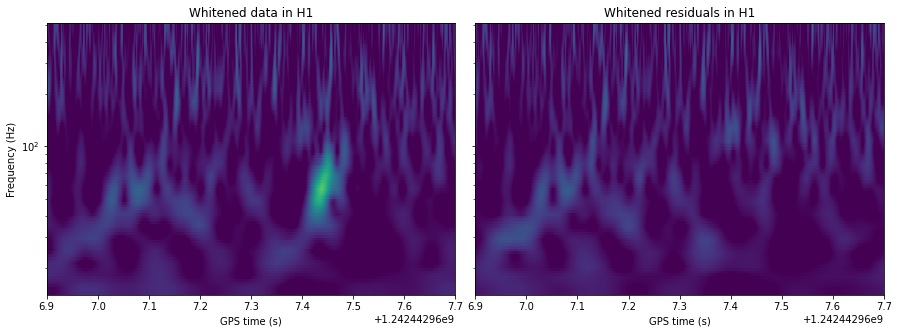

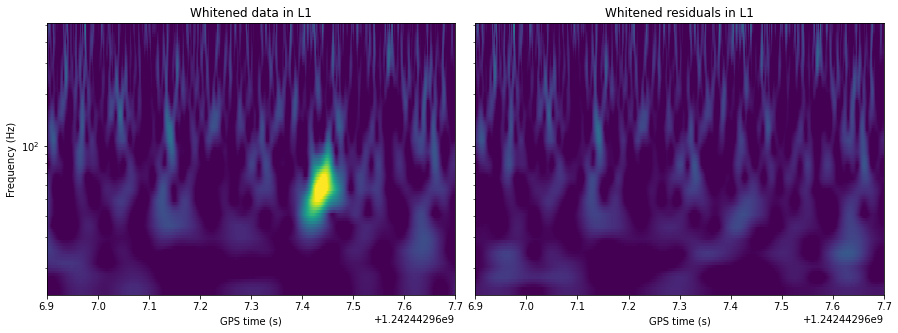

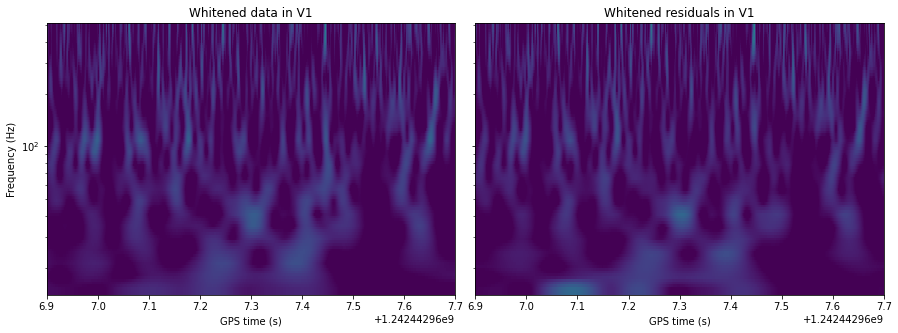

In [19]:
ta = m.time - 0.5
tb = m.time + 0.3

for ifo in ifos:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[15, 5], sharey=True)
    
    # Plot data
    times, freqs, power = zoomed[ifo].qtransform(.001, logfsteps=100,
                                                 qrange=(6, 6),
                                                 frange=(f_low, 512))
    p1 = ax1.pcolormesh(times, freqs, power**0.5, vmin=0.75, vmax=8)
    ax1.set_title("Whitened data in {}".format(ifo))
    ax1.set_xlim(ta, tb)
    ax1.set_ylabel("Frequency (Hz)")
    ax1.set_xlabel("GPS time (s)")

    # Subtract model from data
    zwht = wht[ifo].time_slice(ta, tb)
    zzmed = zoomed[ifo].time_slice(ta, tb)
    subtracted = zzmed - zwht

    # Plot residuals
    times, freqs, power = subtracted.qtransform(.001, logfsteps=100,
                                                 qrange=(6, 6),
                                                 frange=(f_low, 512))
    p2 = ax2.pcolormesh(times, freqs, power**0.5, vmin=0.75, vmax=8)
    ax2.set_title("Whitened residuals in {}".format(ifo))
    ax2.set_yscale('log')
    ax2.set_ylim(f_low, 512)
    ax2.set_xlim(ta, tb)
    ax2.set_xlabel("GPS time (s)")
    plt.subplots_adjust(wspace=0.05)
    plt.show()
    plt.close()

## 4. Significance

Let's look at a bit more of the data around this event, and get a feel for how significant the triggers we have are, and how we might deal with glitches.

First, we will download the 4096 second long data frames from GWOSC. Currently, the `catalog` interface doesn't allow us to retreive this data, so we will download directly via the url. Let's just look at the LIGO detectors for this, as we just want to get a feel for the glitchiness and how effective our re-weighting SNR with $\chi^2$ is.

In [20]:
from pycbc import frame
from astropy.utils.data import download_file

ifos = ["H1", "L1"]
data_filenames = {}
data = {}
PSD = {}

for ifo in ifos:
    print("Processing {} data".format(ifo))
    
    # Download the gravitational wave data for GW170817
    url = "https://www.gw-openscience.org/eventapi/html/GWTC-2/GW190521/v3/{}-{}_GWOSC_4KHZ_R1-1242440920-4096.gwf"
    fname = download_file(url.format(ifo[0], ifo), cache="update")
    data_filenames[ifo] = fname
    
    # Read the gravitational wave data and do some minimal
    # conditioning of the data.
    ts = frame.read_frame(fname, "{}:GWOSC-4KHZ_R1_STRAIN".format(ifo))
    ts = ts.highpass_fir(12, 512)
    data[ifo] = filt.resample_to_delta_t(ts, 1.0/2048)

    p = data[ifo].psd(4)
    p = psd.interpolate(p, data[ifo].delta_f)
    PSD[ifo] = psd.inverse_spectrum_truncation(p, int(2 * data[ifo].sample_rate),
                                               low_frequency_cutoff=f_low)

Processing H1 data
Processing L1 data


What does this data look like?

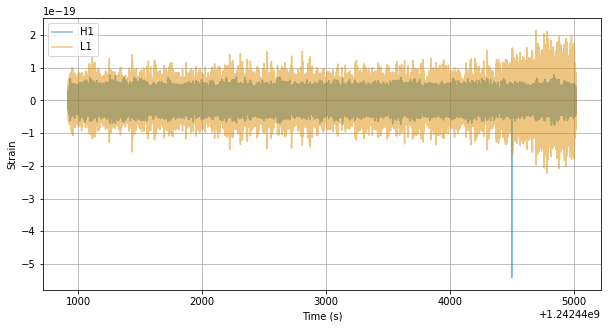

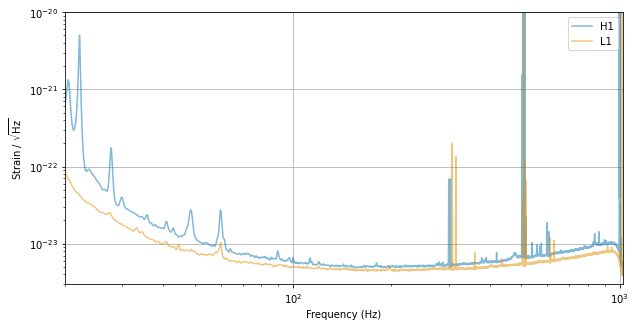

In [21]:
fig = plt.figure(figsize=[10, 5])
ax = plt.gca()
for ifo in ifos:
    ax.plot(data[ifo].sample_times, data[ifo], label=ifo, alpha=alpha)
ax.grid()
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Strain')
plt.show()
plt.close()

fig = plt.figure(figsize=[10, 5])
ax = plt.gca()
for ifo in ifos:
    ax.plot(PSD[ifo].sample_frequencies, PSD[ifo]**0.5, label=ifo, alpha=alpha)
ax.grid()
ax.legend()
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel(r'Strain / $\sqrt{\mathrm{Hz}}$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(3e-24, 1e-20)
ax.set_xlim(20, 1024)
plt.show()
plt.close()

Now let's filter the data. We will use our single, best fitting template from before. In a real search this would be done for $>10^5$ templates, but we can't do that here!

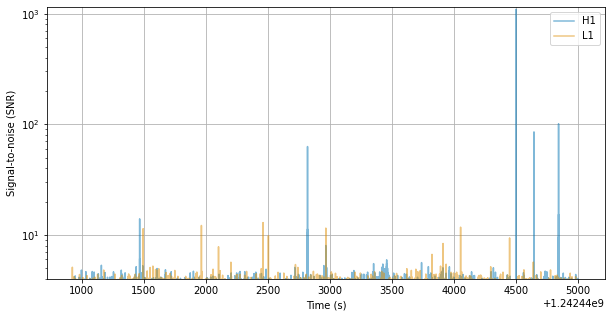

In [22]:
hp_maxL, hc_maxL = wf.get_fd_waveform(approximant=approx,
                                      mass1=maxL_params["mass_1"],
                                      mass2=maxL_params["mass_2"],
                                      spin1x=maxL_params["spin_1x"],
                                      spin1y=maxL_params["spin_1y"],
                                      spin1z=maxL_params["spin_1z"],
                                      spin2x=maxL_params["spin_2x"],
                                      spin2y=maxL_params["spin_2y"],
                                      spin2z=maxL_params["spin_2z"],
                                      distance=maxL_params["luminosity_distance"],
                                      inclination=maxL_params["theta_jn"],
                                      coa_phase=maxL_params["phase"],
                                      f_lower=14.0,
                                      delta_f=PSD[ifo].delta_f)

hp_maxL.resize(len(PSD[ifo]))

snr_full = {}

fig = plt.figure(figsize=[10, 5])
ax = fig.gca()
for ifo in ifos:
    # Do matched filter, filtering data that has noise given by PSD with
    # template hp. We also pass a low frequency argument.
    snr[ifo] = filt.matched_filter(hp_maxL, data[ifo], psd=PSD[ifo],
                                   low_frequency_cutoff=f_low)
    snr[ifo] = snr[ifo].crop(3, 2)
    ax.plot(snr[ifo].sample_times, abs(snr[ifo]), label=ifo,
            alpha=alpha)

ax.legend()
ax.grid()
ax.set_ylim(4, None)
ax.set_yscale("log")
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal-to-noise (SNR)')
plt.show()
plt.close()

In contrast to the 32 second data segment, we now see many SNR spikes, some of which are extremely loud (note the log scale). How will the $\chi^2$ test deal with these?

In [23]:
nbins = 26
chisq = {}
for ifo in ifos:
    chisq[ifo] = power_chisq(hp_maxL, data[ifo], nbins, PSD[ifo],
                             low_frequency_cutoff=f_low)
    chisq[ifo] = chisq[ifo].crop(3, 2)
    dof = nbins * 2 - 2
    chisq[ifo] /= dof

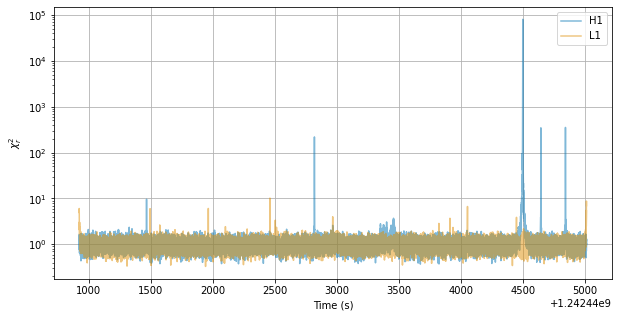

In [24]:
fig = plt.figure(figsize=[10, 5])
ax = fig.gca()
for ifo in ifos:
    ax.plot(chisq[ifo].sample_times, chisq[ifo], label=ifo,
            alpha=alpha)

ax.legend()
ax.grid()
ax.set_yscale("log")
ax.set_xlabel('Time (s)')
ax.set_ylabel(r'$\chi^2_r$')
plt.show()
plt.close()

Here we can see that there are many spikes in the $\chi^2_r$ series, and they tend to align with the SNR spikes. What does the re-weighted detection statistic look like in this case?

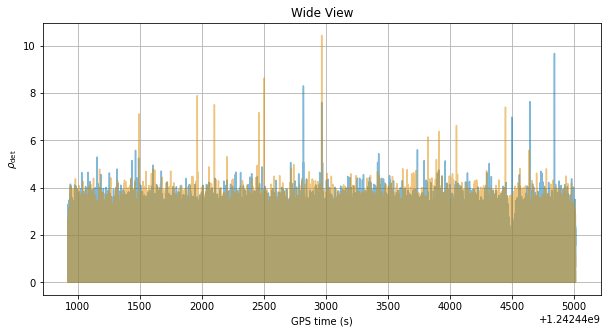

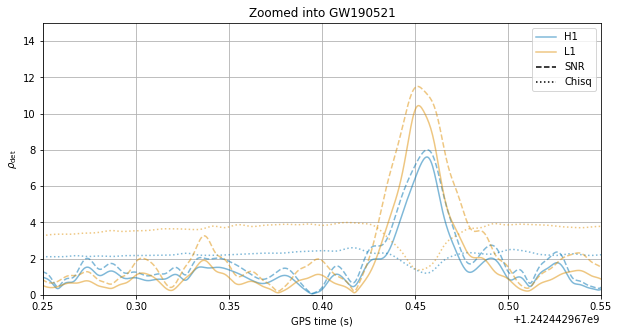

1242442967.456543
1242442967.4521484


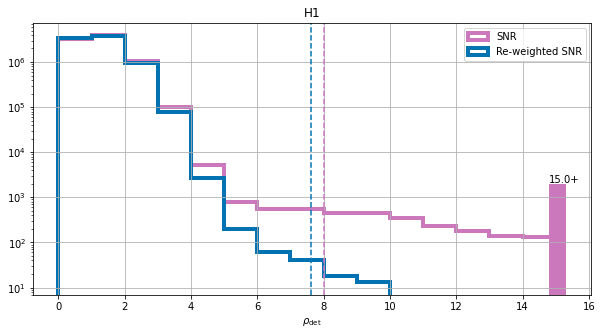

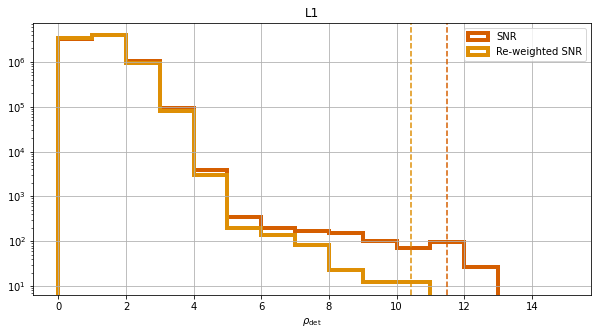

In [25]:
from pycbc import types

nsnr = {ifo: newsnr(abs(snr[ifo]), chisq[ifo]) for ifo in ifos}
nsnr = {ifo: types.TimeSeries(nsnr[ifo], delta_t=snr[ifo].delta_t,
                              epoch=snr[ifo].start_time)
        for ifo in ifos}

for w, title in [(None, "Wide View"), (0.15, "Zoomed into {}".format(m.common_name))]:
    fig = plt.figure(figsize=[10, 5])
    ax = plt.gca()
    for ifo in ifos:
        l = ax.plot(nsnr[ifo].sample_times, nsnr[ifo], label=ifo,
                    alpha=alpha)
        if w is not None:
            ax.plot(snr[ifo].sample_times, abs(snr[ifo]), '--', alpha=alpha,
                    color=l[0].get_color())
            ax.plot(chisq[ifo].sample_times, chisq[ifo], ':', alpha=alpha,
                    color=l[0].get_color())
    if w is not None:
        ax.set_xlim(m.time - w, m.time + w)
        ax.set_ylim(0, 15)
        handles, labels = ax.get_legend_handles_labels()
        snr_line = plt.Line2D([], [], color='black', linestyle="--", label="SNR")
        chisq_line = plt.Line2D([], [], color='black', linestyle=":", label="Chisq")
        ax.legend(handles=handles+[snr_line, chisq_line])
    ax.set_title(title)
    ax.grid()
    ax.set_xlabel('GPS time (s)')
    ax.set_ylabel(r'$\rho_{\mathrm{det}}$')
    plt.show()
    plt.close()

w = 0.15
npeak = {}
for ifo in ifos:
    sliced = nsnr[ifo].time_slice(m.time - w, m.time + w)
    pk, pidx = sliced.abs_max_loc()
    npeak[ifo] = sliced.sample_times[pidx]
    print(npeak[ifo])

# Let's make a histogram to see the effect of the re-weighting here
from pycbc.results import hist_overflow
bins = np.linspace(0, 15, 16)
for ii, ifo in enumerate(ifos):
    fig = plt.figure(figsize=[10, 5])
    ax = plt.gca()
    hist_overflow(abs(snr[ifo]), 15.0, label="SNR", histtype="step", bins=bins, linewidth=4, color=palette[ii+4])
    ax.axvline(abs(snr[ifo].at_time(npeak[ifo])), linestyle="--", color=palette[ii+4])
    hist_overflow(nsnr[ifo], 15.0, label="Re-weighted SNR", histtype="step", bins=bins, linewidth=4, color=palette[ii])
    ax.axvline(nsnr[ifo].at_time(npeak[ifo]), linestyle="--", color=palette[ii])

    ax.legend()
    ax.grid()
    ax.set_title("{}".format(ifo))
    ax.set_xlabel(r'$\rho_{\mathrm{det}}$')
    ax.set_yscale("log")
    plt.show()
    plt.close()

Despite the glitchiness of the data, it's clear that the re-weighting has suppressed most of the worst nosie triggers. In L1 the signal is now the loudest event in the data stretch, and in H1 it is in the top 3 or 4. If we placed single detector SNR thresholds and looked for coincident events with the surviving triggers, GW190512 would be by far the loudest event in the foreground.